# Replication: Nguyen *et al*, 2021

## Introduction

This notebook attempts to reproduce the following paper (which already uses the [PPMI](http://ppmi-info.org) dataset):

<div class="alert alert-block alert-success">
Nguyen KP, et al. <a href=https://doi:10.1016/j.parkreldis.2021.02.026>Predicting Parkinson's disease trajectory using clinical and neuroimaging baseline measures.</a> Parkinsonism Relat Disord. 2021;85:44-51. 
</div>

This study uses data from 82 PD subjects with rs-fMRI and MDS-UPDRS total score, encompassing both motor and non-motor symptomatology at the same visit. Of these 82 subjects, 53 subjects also had scores available at year 1 after imaging, 45 at year 2, and 33 at year 4. 

The fMRI data were acquired at resting-state on 3T scanners with the same acquisition parameters. Acquisition parameters are described below (table extracted from the original paper supplementary materials).

<img src="images/acquisition.png" width=800/>

The demographics parameters for the PD patients were as follows (table extracted from the paper):

<img src="images/demographics.png" width=800/>

The main goal of this paper is to use imaging features extracted from rs-fMRI data and demographic features to train machine learning models to predict MDS-UPDRS scores of PD patients.

Imaging features includes fractional Amplitude of Low Frequency Fluctuations (fALFF) and Regional Homogeneity (ReHo) averaged for different Regions of Interest (ROI) of the brain extracted from different atlases: [100-ROI Schaefer functional brain parcellation](https://doi.org/10.1093/cercor/bhx179), modified with an additional 35 striatal and cerebellar ROIs, 197-ROI and 444-ROI versions of the [Bootstrap Analysis of Stable Clusters (BASC197) atlas](https://doi.org/10.1016/j.neuroimage.2010.02.082).

Different machine learning models were compared: ElasticNet regression, Support Vector Machine (SVM) with a linear kernel, Random Forest with a decision tree kernel, and Gradient Boosting with a decision tree kernel. 

An unbiased random search was conducted to optimize the hyperparameters of each model, including regularization strength and learning rate. To determine the best-performing parcellation, hyperparameter, and model combination for each target, a rigorous nested cross-validation approach was applied, with leave-one-out cross-validation (LOOCV) as the outer loop and 10-fold cross-validation as the inner loop.

ReHo features explained 30.4%, 45.3%, 47.1%, and 25.5% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. fALFF features explained 24.2%, 55.8%, 46.3%, and 15.2% of the variance in baseline, year 1, year 2, and year 4 MDS-UPDRS score, respectively. Results were significant at p = 0.001 (false discovery rate-corrected) at all timepoints except year 4, which was significant at p = 0.05.

Results are displayed below (table extracted from the original paper). 
<img src="images/results.png" width=800/>

## Initial setup

We first initialize the notebook cache and install dependencies:

In [3]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)

This notebook was run on 2023-08-31 18:57:38 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as closely as possible. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 

* Participant status (Parkinson's disease, healthy control, etc.)
* Demographics
* Age at visit
* Clinical/cognitive assessment results:
    * Montreal Cognitive Assessment (MoCA)
    * Unified Parkinson's Disease Rating Scale (UPDRS) Parts I, II and III
    * Geriatric Depression Scale (GDS)
    * Hoehn-Yahr stage

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, a PPMI username and password are required to obtain the files. New PPMI accounts can be requested [here](http://ppmi-info.org).

In [4]:
from nguyenetal.constants import (
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_DEMOGRAPHICS,
    FILENAME_PD_HISTORY,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS3_CLEAN,
    FILENAME_UPDRS4,
    FILENAME_GDS,
    FILENAME_FMRI_INFO,
    FILENAME_FMRI_INFO_ZIP,
    FILENAME_FMRI_METADATA
)

from nguyenetal.constants import (
    COL_PAT_ID,
    COL_VISIT_TYPE,
    COL_STATUS,
    COL_PD_STATE,
    COL_AGE,
    COL_SEX,
    COL_EDUCATION,
    COL_UPDRS3,
    COL_UPDRS1A,
    COL_UPDRS1B,
    COL_UPDRS1,
    COL_UPDRS2,
    COL_UPDRS4,
    COL_MOCA,
)

from nguyenetal.constants import (
    COL_DATE_INFO,
    COL_DATE_BIRTH,
    COL_DATE_PD,
    FIELD_STRENGTH,
    STATUS_PD
    
)

from nguyenetal.constants import (
    COL_IMAGING_PROTOCOL,
    COLS_DATE, 
    IDA_STATUS_MAP,
    IDA_COLNAME_MAP,
    IDA_VISIT_MAP,
    STATUS_MED,
)

from nguyenetal.nguyenetal import (
    load_ppmi_csv,
    get_fMRI_cohort,
    mean_impute,
    compute_summary_features,
    get_features,
    get_threshold, 
    get_outcome_measures
)

from livingpark_utils.scripts import pd_status
from livingpark_utils.dataset.ppmi import disease_duration

from functools import reduce
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 500)
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
#sns.set_palette("rocket")

In [5]:
from livingpark_utils.download.ppmi import Downloader

required_files = [
    FILENAME_PARTICIPANT_STATUS,
    FILENAME_PD_HISTORY,
    FILENAME_DEMOGRAPHICS,
    FILENAME_SOCIO,
    FILENAME_AGE,
    FILENAME_MOCA,
    FILENAME_UPDRS1A,
    FILENAME_UPDRS1B,
    FILENAME_UPDRS2,
    FILENAME_UPDRS3,
    FILENAME_UPDRS4,
    FILENAME_GDS
]

downloader = Downloader(utils.study_files_dir)
utils.get_study_files(required_files, default=downloader)

## ASK TO BUILD A PPMI DOWNLOADER FOR FMRI CSV 

Download skipped: No missing files!


In [6]:
import ppmi_downloader
import os
mri_file_name = "fMRI_info.csv"
if not os.path.exists(os.path.join(utils.study_files_dir, mri_file_name)):
    ppmi = ppmi_downloader.PPMIDownloader()
    file_name = ppmi.download_fmri_info(destination_dir=utils.study_files_dir)
    os.rename(
        os.path.join(utils.study_files_dir, file_name),
        os.path.join(utils.study_files_dir, mri_file_name),
    )

The main cohort contains 82 participants from either the `Parkinson's Disease` or the `GenCohort PD` cohort of PPMI. These 82 participants have rs-fMRI and outcome scores at the same visit available. MDS-UPDRS scores included the Part III Motor Examination conducted on-medication. Off-medication scores were not used due to unavailability for over half of the subjects and because examinations are more practically conducted on-medication in the clinic. 

We selected participants that:
* belonged to the selected cohort
* had fMRI scans with same acquisition parameters as those used in the paper.

### Participants with fMRI data available

In [7]:
print(f"=============== fMRI cohort ===============")
df_status = load_ppmi_csv(utils, FILENAME_PARTICIPANT_STATUS)
df_fMRI_subset = get_fMRI_cohort(utils)

# cohort composition: number of PD patients/healthy controls
print(
    df_status.loc[
        df_status[COL_PAT_ID].isin(df_fMRI_subset[COL_PAT_ID]), COL_STATUS
    ].value_counts()
)

=============== fMRI cohort ===============
Using fMRI info file: /Users/egermani/Documents/nguyen-etal-2021/inputs/study_files/fMRI_info.csv
Dropping 258 subjects with non-integer IDs
COHORT_DEFINITION
Parkinson's Disease    118
Name: count, dtype: int64


Then, we load/compute and merge all the required clinical/cognitive measures:
* UPDRS Part I
* UPDRS Part II
* UPDRS Part III
* UPDRS Part IV
* MoCA
* GDS Score

Missing values are imputed with the mean across the entire dataset, except for the UPDRS Part III score (handled below).

There are two files associated with UPDRS Part I (IA: Complex behaviors; IB: Partipant questionnaire). We use the sum of the total score in each file.

In [8]:
cols_for_merge = [COL_PAT_ID, COL_DATE_INFO, COL_VISIT_TYPE]

# Load necessary files
df_updrs1a = load_ppmi_csv(utils, FILENAME_UPDRS1A, convert_int = [COL_UPDRS1A], cols_to_impute=COL_UPDRS1A)
df_updrs1b = load_ppmi_csv(utils, FILENAME_UPDRS1B, convert_int = [COL_UPDRS1B], cols_to_impute=COL_UPDRS1B)
df_updrs2 = load_ppmi_csv(utils, FILENAME_UPDRS2, convert_int = [COL_UPDRS2], cols_to_impute=COL_UPDRS2)
df_updrs3 = load_ppmi_csv(utils, FILENAME_UPDRS3_CLEAN, convert_int = [COL_UPDRS3])
df_updrs4 = load_ppmi_csv(utils, FILENAME_UPDRS4, convert_int = [COL_UPDRS4], cols_to_impute=COL_UPDRS4)

df_moca = load_ppmi_csv(utils, FILENAME_MOCA, convert_int = [COL_MOCA])
df_gds = load_ppmi_csv(utils, FILENAME_GDS)

# Sum UPDRS IA and IB scores
df_updrs1 = df_updrs1a.merge(df_updrs1b, on=cols_for_merge)
df_updrs1[COL_UPDRS1] = df_updrs1.loc[:, [COL_UPDRS1A, COL_UPDRS1B]].sum(axis="columns")

# Drop unused UPDRSIII scores (only ON medication)
df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDRS3') & \
                         (df_updrs3['EVENT_ID'].isin(['V04', 'V06', 'V08', 'V10', 'V12', 'V13', 'V15']))])
#df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDR3OF')])
#df_updrs3 = df_updrs3.drop(df_updrs3.index[(df_updrs3['PAG_NAME'] == 'NUPDR3ON')])

# Select UPDRS columns to merge
df_updrs1 = df_updrs1.loc[:, cols_for_merge + [COL_UPDRS1]]
df_updrs2 = df_updrs2.loc[:, cols_for_merge + [COL_UPDRS2]]
df_updrs3 = df_updrs3.loc[:, cols_for_merge + [COL_UPDRS3, 'NHY', 'PAG_NAME', 'PDSTATE']]
df_updrs4 = df_updrs4.loc[:, cols_for_merge + [COL_UPDRS4]]

# Compute GDS total score 
gds_cols = df_gds.columns[['GDS' in strcol for strcol in df_gds.columns]].tolist()
df_gds['GDS_TOTAL'] = df_gds[gds_cols].sum(axis=1)
df_gds = df_gds.loc[:, cols_for_merge + ['GDS_TOTAL']]

# Select MOCA columns to merge
df_moca = df_moca.loc[:, cols_for_merge + [COL_MOCA]]

# Merge 
df_assessments_all = reduce(
    lambda df1, df2: df1.merge(df2, on=cols_for_merge, how="outer"),
    [df_updrs2, df_updrs3, df_updrs1, df_updrs4, df_moca, df_gds],
).drop_duplicates()

# Compute TOTAL UPDRS SCORE 
updrs_cols = [COL_UPDRS1, COL_UPDRS2, COL_UPDRS3, COL_UPDRS4]
df_assessments_all['UPDRS_TOT'] = df_assessments_all[updrs_cols].sum(axis=1)
   
# Only keep cohort participants
df_cohort_assessments = df_assessments_all.loc[
    df_assessments_all[COL_PAT_ID].isin(df_fMRI_subset[COL_PAT_ID])]

# Drop participants that don't have UPDRS III Score
df_cohort_assessments = df_cohort_assessments.dropna(subset=['NP3TOT'])

Only participants with outcome score (UPDRS) and rs-fMRI data at the same visit were used, so we filter both datasets to keep only participants sessions that have both. 

In [9]:
df_fMRI_cohort = pd.DataFrame()
for i in range(len(df_cohort_assessments)):
    df_fMRI_cohort = pd.concat([df_fMRI_cohort, 
                        df_fMRI_subset[df_fMRI_subset[COL_PAT_ID] == df_cohort_assessments.iloc[i][COL_PAT_ID]]\
                        [df_fMRI_subset[COL_VISIT_TYPE] == df_cohort_assessments.iloc[i][COL_VISIT_TYPE]]]
                        )
    
df_scores_cohort = pd.DataFrame()
for i in range(len(df_fMRI_subset)):
    df_scores_cohort = pd.concat([df_scores_cohort, 
                    df_cohort_assessments[df_cohort_assessments[COL_PAT_ID] == df_fMRI_subset.iloc[i][COL_PAT_ID]]\
                    [df_cohort_assessments[COL_VISIT_TYPE] == df_fMRI_subset.iloc[i][COL_VISIT_TYPE]]]
                    )

In [11]:
fMRI_cols_to_include = ['PATNO', 'Sex','COHORT_DEFINITION','EVENT_ID', 'INFODT', 'Age', 
                        'Description', 'Imaging Protocol', 'Image ID']
scores_cols_to_include = ['PATNO', 'EVENT_ID','PAG_NAME' ,'NP2PTOT', 'NP3TOT', 'NP1RTOT+NP1PTOT',
       'NP4TOT', 'NHY','MCATOT', 'GDS_TOTAL', 'UPDRS_TOT']

df_fMRI_cohort = df_fMRI_cohort.loc[:, fMRI_cols_to_include]
df_scores_cohort = df_scores_cohort.loc[:, scores_cols_to_include]

# Merge important columns from both datasets
df_global_cohort = df_fMRI_cohort.merge(df_scores_cohort, on=[COL_PAT_ID, COL_VISIT_TYPE])
df_global_cohort = df_global_cohort.sort_values(by=['PATNO','INFODT'])

### Baseline cohort

For the training, authors used the first scan & outcome score available for each participant. 

In [12]:
df_global_cohort_baseline = df_global_cohort.drop_duplicates(subset=COL_PAT_ID)
df_global_cohort_baseline = df_global_cohort_baseline[
    df_global_cohort_baseline[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)
    ] # Removed due to the date of the study

In [13]:
print('Number of participants selected using papers informations:', len(df_global_cohort_baseline))

Number of participants selected using papers informations: 102


### Prediction cohort 

In the paper, authors are trying to predict UPDRS scores at baseline (same session as fMRI data), 1 year after, 2 years after and 4 years after. 

In [14]:
# DF with outcome scores for every participants
df_global_cohort_pred = df_cohort_assessments[df_cohort_assessments\
                                              [COL_PAT_ID].isin(df_global_cohort_baseline[COL_PAT_ID].tolist())]

# Filter by date due to the date of publication of the paper. 
df_global_cohort_pred = df_global_cohort_pred[df_global_cohort_pred[COL_DATE_INFO] < pd.Timestamp(2020, 1, 1, 12)]

# Event taken as Baseline
df_global_cohort_pred['BASELINE_EV'] = [df_global_cohort_baseline[COL_VISIT_TYPE]\
                [df_global_cohort_baseline[COL_PAT_ID] == df_global_cohort_pred[COL_PAT_ID].iloc[i]].iloc[0] \
                             for i in range(len(df_global_cohort_pred))]


In [15]:
eq_1year = {
    'BL':'V04',
    'ST':'V04',
    'V04':'V06',
    'V06':'V08',
    'V08':'V10',
    'V10':'V12'
}

eq_2year = {
    'BL':'V06',
    'ST':'V06',
    'V04':'V08',
    'V06':'V10',
    'V08':'V12',
    'V10':'V13'
}

eq_4year = {
    'BL':'V10',
    'ST':'V10',
    'V04':'V12',
    'V06':'V13',
    'V08':'V14',
    'V10':'V15'
}

In [16]:
df_global_cohort_pred['1Y_EVENT'] = [eq_1year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['2Y_EVENT'] = [eq_2year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]
df_global_cohort_pred['4Y_EVENT'] = [eq_4year[b] for b in df_global_cohort_pred['BASELINE_EV'].tolist()]

In [17]:
df_global_1y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['1Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_1y = df_global_1y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_2y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['2Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_2y = df_global_2y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

df_global_4y = df_global_cohort_pred[
        df_global_cohort_pred[COL_VISIT_TYPE]==df_global_cohort_pred['4Y_EVENT']
    ].drop_duplicates(subset=COL_PAT_ID)

df_global_4y = df_global_4y.merge(df_global_cohort_baseline[['PATNO','Sex']], on=['PATNO'])

In [18]:
print('Number of participants for 1y cohort: ', len(df_global_1y))
print('Number of participants for 2y cohort: ', len(df_global_2y))
print('Number of participants for 4y cohort: ', len(df_global_4y))

Number of participants for 1y cohort:  63
Number of participants for 2y cohort:  68
Number of participants for 4y cohort:  47


### Global cohort

Using the information that we had in the paper, we were able to select 105 participants against 82 mentioned in the paper. We create a demographics table similar to the one in the original paper to verify our cohort. 

In [19]:
df_allyears_summary = pd.DataFrame(columns = [('Baseline', 'Original'), ('Baseline', 'Replication'),
                                              ('Year 1', 'Original'), ('Year 1', 'Replication'), 
                                              ('Year 2', 'Original'), ('Year 2', 'Replication'), 
                                              ('Year 4', 'Original'), ('Year 4', 'Replication')])

df_allyears_summary[('Baseline', 'Original')]=['95.1','2.4','3.7','1.2','67.0','89.0','62.1 ± 9.8',
 '15.6 ± 3.0','770 ± 565','33.9 ± 15.8','-','26.7 ± 2.8','5.4 ± 1.4','1.8 ± 0.5']

df_allyears_summary[('Year 1', 'Original')] = ['94.4','1.9','5.6','0','68.5','85.2','61.9 ± 10.3',
 '15.1 ± 3.2','808 ± 576','38.0 ± 20.9','39.2 ± 21.6','26.9 ± 3.2','5.4 ± 1.6','1.8 ± 0.5']

df_allyears_summary[('Year 2', 'Original')] = ['97.8','0','4.4','0','82.2','88.9','63.6 ± 9.2',
 '15.1 ± 3.3','771 ± 506','40.2 ± 18.2','40.9 ± 18.5','26.7 ± 3.5','5.4 ± 1.2','1.8 ± 0.5']

df_allyears_summary[('Year 4', 'Original')] = ['97.0','0','3.0','0','75.8','87.9','59.5 ± 11.0',
    '15.0 ± 3.4','532 ± 346','34.9 ± 15.7','35.9 ± 16.5','27.5 ± 2.3','5.4 ± 1.7','1.7 ± 0.5']

df_allyears_summary[('Baseline', 'Replication')] = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').tolist()
df_allyears_summary[('Year 1', 'Replication')] = compute_summary_features(df_global_1y, utils,
                                                                '1Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 2', 'Replication')] = compute_summary_features(df_global_2y, utils,
                                                                '2Y', df_global_cohort_baseline).tolist()
df_allyears_summary[('Year 4', 'Replication')] = compute_summary_features(df_global_4y, utils,
                                                                '4Y', df_global_cohort_baseline).tolist()

df_allyears_summary.index = compute_summary_features(df_global_cohort_baseline, utils,
                                                                'baseline').index

df_allyears_summary.loc['Number of subject'] = [82, len(df_global_cohort_baseline), 53, len(df_global_1y), 
                                      45, len(df_global_2y), 33, len(df_global_4y)]

df_allyears_summary.columns = pd.MultiIndex.from_tuples(df_allyears_summary.columns)
df_allyears_summary

Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!


Baseline                 \
                                            Original    Replication   
% Caucasian                                     95.1           95.1   
% African-American                               2.4            2.0   
% Asian                                          3.7            2.9   
% Hispanic                                       1.2            1.0   
% Male                                          67.0           66.7   
% right-handed                                  89.0           89.2   
Mean age, years                           62.1 ± 9.8     62.1 ± 9.5   
Mean years of education                   15.6 ± 3.0     15.6 ± 2.8   
Mean disease duration at baseline, days    770 ± 565  870.4 ± 597.1   
Mean MDS-UPDRS at baseline               33.9 ± 15.8    34.5 ± 15.6   
Mean MDS-UPDRS at timepoint                        -              -   
Mean MoCA at baseline                     26.7 ± 2.8     26.5 ± 3.0   
Mean GDS at Baseline                       5.4 ± 1.4      5.4 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 82            102   

                                              Year 1                 \
                                            Original    Replication   
% Caucasian                                     94.4           95.2   
% African-American                               1.9            1.6   
% Asian                                          5.6            3.2   
% Hispanic                                         0            1.6   
% Male                                          68.5           65.1   
% right-handed                                  85.2           87.3   
Mean age, years                          61.9 ± 10.3     62.5 ± 9.7   
Mean years of education                   15.1 ± 3.2     15.1 ± 2.6   
Mean disease duration at baseline, days    808 ± 576  998.3 ± 593.1   
Mean MDS-UPDRS at baseline               38.0 ± 20.9    33.7 ± 15.3   
Mean MDS-UPDRS at timepoint              39.2 ± 21.6    39.5 ± 22.2   
Mean MoCA at baseline                     26.9 ± 3.2     27.0 ± 2.9   
Mean GDS at Baseline                       5.4 ± 1.6      5.5 ± 1.7   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 53             63   

                                              Year 2                 \
                                            Original    Replication   
% Caucasian                                     97.8           97.1   
% African-American                                 0            0.0   
% Asian                                          4.4            2.9   
% Hispanic                                         0            1.5   
% Male                                          82.2           76.5   
% right-handed                                  88.9           91.2   
Mean age, years                           63.6 ± 9.2     63.5 ± 9.8   
Mean years of education                   15.1 ± 3.3     15.3 ± 2.7   
Mean disease duration at baseline, days    771 ± 506  902.9 ± 566.4   
Mean MDS-UPDRS at baseline               40.2 ± 18.2    34.0 ± 15.2   
Mean MDS-UPDRS at timepoint              40.9 ± 18.5    40.7 ± 19.7   
Mean MoCA at baseline                     26.7 ± 3.5     26.9 ± 2.4   
Mean GDS at Baseline                       5.4 ± 1.2      5.5 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.8 ± 0.5   
Number of subject                                 45             68   

                                              Year 4                 
                                            Original    Replication  
% Caucasian                                     97.0           97.9  
% African-American                                 0            0.0  
% Asian                                          3.0            2.1  
% Hispanic                                         0            0.0  


The values obtained in this table are basically similar to those in the paper, except in terms of number of participants. The original baseline cohort was composed of 82 participants compared to 102 in our case. Year 1, 2 and 4 cohorts also exhibit a larger number of participants than in the original paper. 

Mean values of demographics and clinical features are similar to those of the original paper. 

To obtain the same number of participants in each cohort, we will randomly sample the same number of participants as those used in the paper and perform the replication on these participants.

### Final cohort: resampling to obtain similar sample sizes

In [20]:
participants_1pred_scores = [sub for sub in df_global_cohort_baseline[COL_PAT_ID].tolist() \
                           if (sub in df_global_1y[COL_PAT_ID].tolist()) or \
                          (sub in df_global_2y[COL_PAT_ID].tolist()) or \
                          (sub in df_global_4y[COL_PAT_ID].tolist())]

print('Number of participants with AT LEAST one prediction score:', len(participants_1pred_scores))

random_sampling = np.random.choice(participants_1pred_scores, size=82, replace=False)

print('Number of participant in random sampling for baseline:', len(random_sampling))

random_1y = [sub for sub in random_sampling if sub in df_global_1y[COL_PAT_ID].tolist()]
random_2y = [sub for sub in random_sampling if sub in df_global_2y[COL_PAT_ID].tolist()]
random_4y = [sub for sub in random_sampling if sub in df_global_4y[COL_PAT_ID].tolist()]

print('Number of participant in random sampling for 1y:', len(random_1y))
print('Number of participant in random sampling for 2y:', len(random_2y))
print('Number of participant in random sampling for 4y:', len(random_4y))

Number of participants with AT LEAST one prediction score: 89
Number of participant in random sampling for baseline: 82
Number of participant in random sampling for 1y: 60
Number of participant in random sampling for 2y: 62
Number of participant in random sampling for 4y: 43


In [21]:
# FINAL COHORT 
df_cohort_baseline = df_global_cohort_baseline[df_global_cohort_baseline[COL_PAT_ID].isin(random_sampling)]
df_cohort_1y = df_global_1y[df_global_1y[COL_PAT_ID].isin(random_1y)]
df_cohort_2y = df_global_2y[df_global_2y[COL_PAT_ID].isin(random_2y)]
df_cohort_4y = df_global_4y[df_global_4y[COL_PAT_ID].isin(random_4y)]

In [22]:
# Plot demographic features for this cohort
df_allyears_summary_cohort = pd.DataFrame(columns = [('Baseline', 'Original'), ('Baseline', 'Replication'),
                                              ('Year 1', 'Original'), ('Year 1', 'Replication'), 
                                              ('Year 2', 'Original'), ('Year 2', 'Replication'), 
                                              ('Year 4', 'Original'), ('Year 4', 'Replication')])

df_allyears_summary_cohort[('Baseline', 'Original')]=['95.1','2.4','3.7','1.2','67.0','89.0','62.1 ± 9.8',
 '15.6 ± 3.0','770 ± 565','33.9 ± 15.8','-','26.7 ± 2.8','5.4 ± 1.4','1.8 ± 0.5']

df_allyears_summary_cohort[('Year 1', 'Original')] = ['94.4','1.9','5.6','0','68.5','85.2','61.9 ± 10.3',
 '15.1 ± 3.2','808 ± 576','38.0 ± 20.9','39.2 ± 21.6','26.9 ± 3.2','5.4 ± 1.6','1.8 ± 0.5']

df_allyears_summary_cohort[('Year 2', 'Original')] = ['97.8','0','4.4','0','82.2','88.9','63.6 ± 9.2',
 '15.1 ± 3.3','771 ± 506','40.2 ± 18.2','40.9 ± 18.5','26.7 ± 3.5','5.4 ± 1.2','1.8 ± 0.5']

df_allyears_summary_cohort[('Year 4', 'Original')] = ['97.0','0','3.0','0','75.8','87.9','59.5 ± 11.0',
    '15.0 ± 3.4','532 ± 346','34.9 ± 15.7','35.9 ± 16.5','27.5 ± 2.3','5.4 ± 1.7','1.7 ± 0.5']

df_allyears_summary_cohort[('Baseline', 'Replication')] = compute_summary_features(df_cohort_baseline, utils,
                                                                'baseline').tolist()
df_allyears_summary_cohort[('Year 1', 'Replication')] = compute_summary_features(df_cohort_1y, utils,
                                                                '1Y', df_cohort_baseline).tolist()
df_allyears_summary_cohort[('Year 2', 'Replication')] = compute_summary_features(df_cohort_2y, utils,
                                                                '2Y', df_cohort_baseline).tolist()
df_allyears_summary_cohort[('Year 4', 'Replication')] = compute_summary_features(df_cohort_4y, utils,
                                                                '4Y', df_cohort_baseline).tolist()

df_allyears_summary_cohort.index = compute_summary_features(df_cohort_baseline, utils,
                                                                'baseline').index

df_allyears_summary_cohort.loc['Number of subject'] = [82, len(df_cohort_baseline), 53, len(df_cohort_1y), 
                                      45, len(df_cohort_2y), 33, len(df_cohort_4y)]

df_allyears_summary_cohort.columns = pd.MultiIndex.from_tuples(df_allyears_summary_cohort.columns)
df_allyears_summary_cohort

Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!
Download skipped: No missing files!


Baseline                 \
                                            Original    Replication   
% Caucasian                                     95.1           96.3   
% African-American                               2.4            1.2   
% Asian                                          3.7            2.4   
% Hispanic                                       1.2            1.2   
% Male                                          67.0           67.1   
% right-handed                                  89.0           87.8   
Mean age, years                           62.1 ± 9.8     61.5 ± 9.7   
Mean years of education                   15.6 ± 3.0     15.6 ± 2.7   
Mean disease duration at baseline, days    770 ± 565  923.6 ± 607.8   
Mean MDS-UPDRS at baseline               33.9 ± 15.8    34.6 ± 16.5   
Mean MDS-UPDRS at timepoint                        -              -   
Mean MoCA at baseline                     26.7 ± 2.8     26.8 ± 2.8   
Mean GDS at Baseline                       5.4 ± 1.4      5.3 ± 1.2   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.7 ± 0.5   
Number of subject                                 82             82   

                                              Year 1                  \
                                            Original     Replication   
% Caucasian                                     94.4            95.0   
% African-American                               1.9             1.7   
% Asian                                          5.6             3.3   
% Hispanic                                         0             1.7   
% Male                                          68.5            63.3   
% right-handed                                  85.2            86.7   
Mean age, years                          61.9 ± 10.3      61.9 ± 9.4   
Mean years of education                   15.1 ± 3.2      15.2 ± 2.6   
Mean disease duration at baseline, days    808 ± 576  1019.2 ± 599.0   
Mean MDS-UPDRS at baseline               38.0 ± 20.9     33.5 ± 15.4   
Mean MDS-UPDRS at timepoint              39.2 ± 21.6     39.8 ± 22.6   
Mean MoCA at baseline                     26.9 ± 3.2      27.0 ± 2.9   
Mean GDS at Baseline                       5.4 ± 1.6       5.5 ± 1.6   
Mean Hoehn-Yahr stage                      1.8 ± 0.5       1.7 ± 0.5   
Number of subject                                 53              60   

                                              Year 2                 \
                                            Original    Replication   
% Caucasian                                     97.8           98.4   
% African-American                                 0            0.0   
% Asian                                          4.4            1.6   
% Hispanic                                         0            1.6   
% Male                                          82.2           74.2   
% right-handed                                  88.9           91.9   
Mean age, years                           63.6 ± 9.2     63.0 ± 9.7   
Mean years of education                   15.1 ± 3.3     15.4 ± 2.7   
Mean disease duration at baseline, days    771 ± 506  922.4 ± 572.8   
Mean MDS-UPDRS at baseline               40.2 ± 18.2    34.0 ± 15.6   
Mean MDS-UPDRS at timepoint              40.9 ± 18.5    40.9 ± 20.6   
Mean MoCA at baseline                     26.7 ± 3.5     27.1 ± 2.3   
Mean GDS at Baseline                       5.4 ± 1.2      5.5 ± 1.4   
Mean Hoehn-Yahr stage                      1.8 ± 0.5      1.8 ± 0.5   
Number of subject                                 45             62   

                                              Year 4                 
                                            Original    Replication  
% Caucasian                                     97.0          100.0  
% African-American                                 0            0.0  
% Asian                                          3.0            0.0  
% Hispanic                                         0 

## Imaging features

We create a dataframe with only informations regarding the images of participants for each cohort. 

In [24]:
df_fmri_cohort_baseline = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']]

df_fmri_cohort_1y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_fmri_cohort_2y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_fmri_cohort_4y = df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

fMRI data are associated with anatomical T1 data, often necessary for preprocessing. 

We searched for the T1 data acquired during the same session as the fMRI ones for the baseline cohort. We chose the first one each time.

In [25]:
from livingpark_utils.scripts import run
from livingpark_utils.scripts import mri_metadata

run.mri_metadata()

This notebook was run on 2023-08-31 19:00:11 UTC +0000


LivingPark-utils|DEBUG|ppmi_downloader.py:173 in __init__()
                       self.driver.desired_capabilities: {'acceptInsecureCerts': False,
                                                          'browserName': 'chrome',
                                                          'browserVersion': '116.0.5845.140',
                                                          'chrome': {'chromedriverVersion': '116.0.5845.96 '
                                                                                            '(1a391816688002153ef791ffe60d9e899a71a037-refs/branch-heads/5845@{#1382})',
                                                                     'userDataDir': '/var/folders/k4/cck9mrt578q044z6x6zmsnc400m_jt/T/.org.chromium.Chromium.5rJxHt'},
                                                          'fedcm:accounts': True,
                                                          'goog:chromeOptions': {'debuggerAddress': 'localhost:57961'},
                            

['COR', 'Coronal', 'Cal Head 24', 'Transverse', 'tra_T1_MPRAGE', 'TRA']
['AX', 'Ax', 'axial', 'Phantom', 'T2']
{'Screening': 'SC', 'Baseline': 'BL', 'Month 6': 'V02', 'Month 12': 'V04', 'Month 24': 'V06', 'Month 36': 'V08', 'Month 48': 'V10', 'Symptomatic Therapy': 'ST', 'Unscheduled Visit 01': 'U01', 'Unscheduled Visit 02': 'U02', 'Premature Withdrawal': 'PW'}
Saved in MRI_info.csv


In [27]:
df_mri = load_ppmi_csv(utils, '3D_mri_info.csv', from_ida_search=True)

df_mri_cohort_baseline = df_mri.merge(df_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE]], 
                      on = [COL_PAT_ID, COL_VISIT_TYPE])
df_mri_cohort_baseline = df_mri_cohort_baseline.sort_values(by=[COL_PAT_ID,'Description'])
df_mri_cohort_baseline = df_mri_cohort_baseline.drop_duplicates(subset=[COL_PAT_ID])

df_mri_cohort_1y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_1y[COL_PAT_ID].tolist())]

df_mri_cohort_2y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_2y[COL_PAT_ID].tolist())]

df_mri_cohort_4y = df_mri_cohort_baseline[[COL_PAT_ID, COL_VISIT_TYPE, 'Description', 
                                              'Imaging Protocol', 'Image ID']][
                                        df_mri_cohort_baseline[COL_PAT_ID].isin(df_cohort_4y[COL_PAT_ID].tolist())]

Dropping 3 subjects with non-integer IDs


## Download preprocessed images 

## Compute imaging features

In [29]:
import sys 
sys.path.append("/Users/egermani/Documents/C-PAC")

import glob, os
from nilearn import image as nilimage
from nipype.pipeline.engine import Workflow, Node, JoinNode
from nipype import IdentityInterface, Rename, DataSink
from nipype.interfaces.fsl import ExtractROI, Merge
from CPAC.alff import alff
from CPAC.reho import reho

def static_measures(func_image, mask_image, output_dir,
                    high_pass_filter=0.01, low_pass_filter=0.1, cluster_size=27, n_job=1):
    '''
    Compute static ALFF, fALFF, and ReHo for an fMRI image.

    :param func_image: path to preprocessed (normalized, denoised, etc.) fMRI NIfTI file
    :type func_image: str
    :param mask_image: path to binary brain mask NIfTI file
    :type mask_iamge: str
    :param output_dir: path to output directory
    :type output_dir: str
    :param high_pass_filter: cutoff in Hz for highpass filter. Default 0.01 Hz
    :type high_pass_filter: float
    :param low_pass_filter: cutoff in Hz for lowpass filter. Default 0.1 Hz
    :type low_pass_filter: float
    :param cluster_size: cluster size (neighborhood) for ReHo computation. Can be 7, 19, or 27. Default 27
    :type cluster_size: int
    :param n_job: number of parallel processes
    :type n_job: int
    '''

    output_dir = os.path.realpath(output_dir)

    if cluster_size not in [7, 19, 27]:
        raise ValueError('{} is not a valid cluster size. Must be 7, 19, or 27'.format(cluster_size))

    workflow = Workflow('static', base_dir=os.path.join(output_dir, 'working_dir'))

    # Compute ALFF and fALFF with CPAC's workflow
    alff_workflow = alff.create_alff('alff_workflow')
    alff_workflow.inputs.hp_input.hp = high_pass_filter
    alff_workflow.inputs.lp_input.lp = low_pass_filter
    alff_workflow.inputs.inputspec.rest_mask = mask_image
    alff_workflow.inputs.inputspec.rest_res = func_image

    # Compute ReHo with CPAC's workflow
    reho_workflow = reho.create_reho('reho_workflow')
    reho_workflow.inputs.inputspec.cluster_size = cluster_size
    reho_workflow.inputs.inputspec.rest_mask = mask_image
    reho_workflow.inputs.inputspec.rest_res_filt = func_image

    # Copy outputs into a user-friendly location
    datasink = Node(DataSink(base_directory=output_dir, remove_dest_dir=True), name='datasink')
    workflow.connect(alff_workflow, 'outputspec.alff_img', datasink, 'results.@alff')
    workflow.connect(alff_workflow, 'outputspec.falff_img', datasink, 'results.@falff')
    workflow.connect(reho_workflow, 'outputspec.raw_reho_map', datasink, 'results.@reho')

    if n_job > 1:
        # Run with multiprocess parallelization
        workflow.run(plugin='MultiProc', plugin_args={'n_procs': n_job})
    else:
        workflow.run()

In [30]:
func_image = '/Users/egermani/Documents/nguyen-etal-2021/inputs/data/Nifti/derivatives/cpac/output/pipeline_cpac-reproduction-pipeline/' +\
                'sub-3107/ses-1/func/sub-3107_ses-1_task-rest_space-template_desc-preproc_bold.nii.gz'
mask_image = '/Users/egermani/Documents/nguyen-etal-2021/inputs/data/Nifti/derivatives/cpac/output/pipeline_cpac-reproduction-pipeline/' +\
                'sub-3107/ses-1/func/sub-3107_ses-1_task-rest_space-template_desc-bold_mask.nii.gz'
output_dir = '/Users/egermani/Documents/nguyen-etal-2021/inputs/data/Nifti/derivatives/cpac/output/pipeline_alff-reho/sub-3107/ses-1/'
static_measures(func_image, mask_image, output_dir,
                    high_pass_filter=0.01, low_pass_filter=0.1, cluster_size=27, n_job=1)

230831-15:02:48,725 nipype.workflow DEBUG:
	 (alff_workflow.hp_input, alff_workflow.bandpass_filtering): No edge data
230831-15:02:48,729 nipype.workflow DEBUG:
	 (alff_workflow.hp_input, alff_workflow.bandpass_filtering): new edge data: {'connect': [('hp', 'highpass')]}
230831-15:02:48,734 nipype.workflow DEBUG:
	 (alff_workflow.lp_input, alff_workflow.bandpass_filtering): No edge data
230831-15:02:48,739 nipype.workflow DEBUG:
	 (alff_workflow.lp_input, alff_workflow.bandpass_filtering): new edge data: {'connect': [('lp', 'lowpass')]}
230831-15:02:48,744 nipype.workflow DEBUG:
	 (alff_workflow.inputspec, alff_workflow.bandpass_filtering): No edge data
230831-15:02:48,748 nipype.workflow DEBUG:
	 (alff_workflow.inputspec, alff_workflow.bandpass_filtering): new edge data: {'connect': [('rest_res', 'in_file')]}
230831-15:02:48,755 nipype.workflow DEBUG:
	 (alff_workflow.inputspec, alff_workflow.get_option_string): No edge data
230831-15:02:48,759 nipype.workflow DEBUG:
	 (alff_workflow.

In [55]:
from nilearn import regions, image, datasets
import numpy as np

def get_mean_ROI_values(feature_path_list, atlas):
    basc_atlas = datasets.fetch_atlas_basc_multiscale_2015()
    schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
    cereb_atlas = './inputs/atlases/striatum-con-label-thr25-7sub-2mm.nii.gz'
    striatum_atlas = './inputs/atlases/Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz'
    
    # Paths to brain atlases
    atlas_dict = {'basc197': basc_atlas['scale197'],
                   'basc444': basc_atlas['scale444'],
                   'schaefer': [schaefer_atlas, cereb_atlas, striatum_atlas]
                   }
    
    atlas_path = atlas_dict[atlas]

    if atlas == 'schaefer':
        atlas_img = image.load_img(atlas_path[0]['maps'])
        atlas_img_res = image.resample_to_img(atlas_img, feature_path_list[0], interpolation='nearest')
        arr_regions, _ = regions.img_to_signals_labels(feature_path_list, atlas_img_res)

        cereb_atlas_img = image.load_img(atlas_path[1])
        cereb_atlas_img_res = image.resample_to_img(cereb_atlas_img, feature_path_list[0], interpolation='nearest')
        arr_regions_cereb, _ = regions.img_to_signals_labels(feature_path_list, cereb_atlas_img_res)

        striatum_atlas_img = image.load_img(atlas_path[2])
        striatum_atlas_img_res = image.resample_to_img(striatum_atlas_img, feature_path_list[0], interpolation='nearest')
        arr_regions_striatum, _ = regions.img_to_signals_labels(feature_path_list, striatum_atlas_img_res)

        arr_cort_cereb = np.append(arr_regions[0], arr_regions_cereb[0])
        arr_cort_cereb_striatum = np.append(arr_cort_cereb, arr_regions_striatum[0])
        
        return arr_cort_cereb_striatum 

    else:
        atlas_img = image.load_img(atlas_path)
        atlas_img_res = image.resample_to_img(atlas_img, feature_path_list[0], interpolation='nearest')
        arr_regions, _ = regions.img_to_signals_labels(feature_path_list, atlas_img_res)
    
        return arr_regions

In [56]:
atlas = 'schaefer'
feature_path_list = ['/Users/egermani/Documents/nguyen-etal-2021/inputs/data/Nifti/derivatives/cpac/output/pipeline_alff-reho/sub-3107/ses-1/results/alff.nii.gz']

get_mean_ROI_values(feature_path_list, atlas)

array([118.08119 ,  79.38078 , 115.4665  ,  73.09084 , 111.07095 ,
       115.016426,  70.53497 ,  77.21383 ,  99.80136 , 105.13374 ,
        97.09281 ,  89.273636,  81.62494 ,  79.046165,  77.91841 ,
        78.37146 ,  72.20114 ,  74.13068 ,  68.45553 ,  88.96897 ,
        63.365192,  83.691925,  73.24425 ,  81.146935, 107.749954,
        82.76628 ,  68.59504 ,  88.24442 ,  79.56259 ,  83.15335 ,
        97.86064 , 100.01421 ,  89.1473  ,  68.56343 ,  75.238815,
       103.30077 ,  84.74892 ,  86.00373 ,  94.529495,  83.580734,
        72.76565 ,  94.82371 ,  79.38327 ,  93.88715 ,  75.06978 ,
        78.03921 ,  85.06971 ,  69.97253 , 125.34729 ,  87.35425 ,
        95.2922  , 107.49602 ,  91.35852 , 104.59047 , 122.42617 ,
       129.15074 ,  94.467804, 104.19575 , 102.276886,  98.9623  ,
        89.63977 ,  77.11955 ,  81.40723 ,  85.59439 ,  81.05563 ,
        77.43789 ,  87.08255 ,  78.86811 ,  74.70795 ,  79.474754,
        71.867165,  76.667046,  73.522964,  87.87284 ,  90.828

## Extracting features for machine learning models

In the paper, authors reported having used different clinical and demographic features along with the radiomic data to train the models. 
These included:
* **Clinical features**: disease duration, symptom duration, dominant symptom side, Geriatric Depression Scale (GDS), Montreal Cognitive Assessment (MoCA), and presence of tremor, rigidity, or postural instability at baseline. Baseline MDS-UPDRS score was also included as a confounding variable when training models to predict future outcomes. 
* **Demographic features**: age, sex, ethnicity, race, handedness, and years of education.

<div class="alert alert-block alert-danger">
    Dominant side is not included on PD features in the PPMI database, so we removed it from the used features.
</div>

In [41]:
df_features_cohort_baseline = get_features(df_cohort_baseline, utils,
                                  df_cohort_baseline[COL_PAT_ID].tolist(), 
                                 timepoint='baseline')

df_features_cohort_1y = get_features(df_cohort_baseline, utils,
                                  df_cohort_1y[COL_PAT_ID].tolist(), 
                                 timepoint='baseline')

df_features_cohort_2y = get_features(df_cohort_baseline, utils,
                                  df_cohort_2y[COL_PAT_ID].tolist(), 
                                 timepoint='baseline')

df_features_cohort_4y = get_features(df_cohort_baseline, utils,
                                  df_cohort_4y[COL_PAT_ID].tolist(), 
                                 timepoint='baseline')

## Extracting outcome measures 

* The outcome of interest is the MDS-UPDRS total score, encompassing both motor and non-motor symptomatology. 
* As a secondary outcome measure, an MDS-UPDRS score threshold was used to dichotomize subjects into high- and low-severity groups. A threshold of 35 was selected, which was the average of the median MDS-UPDRS score at each of the four timepoints.
  
It is mentioned in the paper that there were no differences between the high- and low-severity groups in motor predominance (Part III score as a percentage of total score) at p = 0.05.


In [42]:
threshold = get_threshold(df_cohort_baseline, df_cohort_1y, df_cohort_2y, df_cohort_4y)

In [43]:
df_outcome_baseline = get_outcome_measures(df_cohort_baseline, threshold)
df_outcome_1y = get_outcome_measures(df_cohort_1y, threshold)
df_outcome_2y = get_outcome_measures(df_cohort_2y, threshold)
df_outcome_4y = get_outcome_measures(df_cohort_4y, threshold)

In [44]:
# Verify that there were no differences between the high- and low-severity groups in motor predominance 
# (Part III score as a percentage of total score) at p = 0.05.
from scipy.stats import ttest_ind

for i, df in enumerate([df_outcome_baseline, df_outcome_1y, df_outcome_2y, df_outcome_4y]):
    df['PERC_UPDRS3'] = df['NP3TOT']/df['UPDRS_TOT']

    perc_updrs3_highsev = df['PERC_UPDRS3'][df[f'SEVERITY']==1].tolist()
    perc_updrs3_lowsev = df['PERC_UPDRS3'][df[f'SEVERITY']==0].tolist()

    if i == 0:
        time = 'Baseline'
    elif i < 3:
        time = f'{i+1} years'
    else:
        time = '4 years'
        
    print(time, ':', round(ttest_ind(perc_updrs3_highsev, perc_updrs3_lowsev)[1], 3))

Baseline : 0.179
2 years : 0.05
3 years : 0.493
4 years : 0.392


The distribution of the UPDRS-Score at Baseline and 1 year are also given in the supplementary materials. We tried to reproduce these figures. 

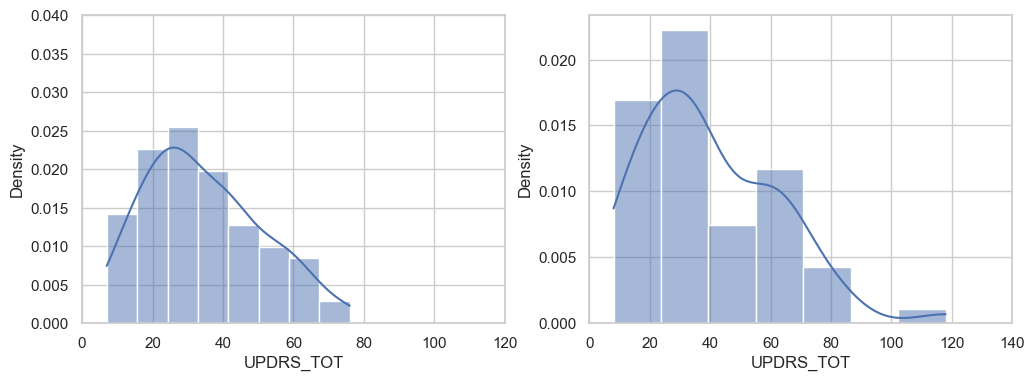

In [45]:
f = plt.figure(figsize = (12, 4))
gs = f.add_gridspec(1, 2)

ax1 = f.add_subplot(gs[0, 0])
ax1.set_xlim(0,120)
ax1.set_ylim(0, 0.04)

sns.histplot(df_outcome_baseline, x = 'UPDRS_TOT', axes=ax1, kde=True, stat='density')
ax2 = f.add_subplot(gs[0, 1])
ax2.set_xlim(0,140)
sns.histplot(df_outcome_1y,
             x = 'UPDRS_TOT', axes=ax2, kde=True, stat='density')
            
plt.show()

Reported plot in the original paper are shown below. 

<img src="images/outcome_distribution.png" width=1000/>

## Implementing machine learning models

In [76]:
from scipy import stats
from sklearn import model_selection, pipeline, preprocessing, impute, feature_selection, metrics, svm, linear_model, \
    ensemble
import copy

In [77]:
class StratifiedKFoldContinuous(model_selection.StratifiedKFold):
    def __init__(self, n_splits=10, n_bins=3, shuffle=True, random_state=989):
        self.n_bins = n_bins
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state = random_state)

    def split(self, X, y, groups=None):
        yBinned = pd.qcut(y, self.n_bins, labels=False, duplicates='drop')
        # yBinned.index = y.index
        return super(StratifiedKFoldContinuous, self).split(X, yBinned, groups)

In [78]:
outer = model_selection.LeaveOneOut()
inner = StratifiedKFoldContinuous()    

In [108]:
def rmse(true, predict):
    return np.sqrt(np.mean(np.square(true - predict)))


def rsquare(true, predict):
    ssTot = np.sum(np.square(true - np.mean(true)))
    ssRes = np.sum(np.square(true - predict))
    return 1 - (ssRes / (ssTot + np.finfo(float).eps))

class RegressorPanel:
    outer: model_selection.BaseCrossValidator
    inner: model_selection.BaseCrossValidator

    def __init__(self, data, target,
                 outer=3,
                 inner=5,
                 metric_rs='rsquare',
                 random_seed=432):
        """
        Set of shallow learning models for regression.

        :param data: dataframe of input data, or a path to a file containing the the input data (CSV or pkl)
        :type data: pandas.DataFrame
        :param target:
        :type target: pandas.DataFrame
        :param outer:
        :type outer:
        :param inner:
        :type inner:
        :param metric_rs: 'rsquare' or 'rmse'; which metric to use to select the best model in each random search
        :type metric_rs: str
        :param random_seed:
        :type random_seed:
        """

        self.data = data
        self.target = target

        if isinstance(outer, int):
            self.outer = model_selection.KFold(n_splits=outer, shuffle=True, random_state=random_seed)
        else:
            self.outer = outer
        if isinstance(inner, int):
            self.inner = model_selection.KFold(n_splits=inner, shuffle=True, random_state=random_seed)
        else:
            self.inner = inner

        self.model_dict = None
        self.set_default_models()
        self.preprocessing = None
        self.set_default_preprocessing()
        self.feature_selection = None
        self.metric_rs = metric_rs
        self.random_seed = random_seed

    def set_models(self, *args):
        """
        Select scikit-learn models to train. Pass in any number of tuples, where each tuple contains a scikit-learn
        regression model class and the dictionary of hyperparameter ranges to search.
        For example, set_models((sklearn.linear_model.Lasso, {'alpha': scipy.stats.uniform(0.1, 10.0),
                                                            'max_iter': scipy.stats.randint(500, 5000)},
                                sklearn.ensemble.RandomForestRegressor, {'n_estimators': stats.randint(200, 12000),
                                                                      'min_samples_split': stats.uniform(0.01, 0.5),
                                                                      'min_samples_leaf': stats.randint(1, 6),
                                                                      'max_depth': stats.randint(1, 10)}
                                )
        If models are not specified, the default models and hyperparameters will be used.

        :param args: tuples containing (regression model, hyperparameter dictionary) pairs
        :type args: tuple
        :return:
        :rtype:
        """
        self.model_dict = {model_tupple[0].__name__: model_tupple for model_tupple in args}

    def set_default_models(self):
        self.model_dict = {'ElasticNet': (linear_model.ElasticNet(max_iter=5000),
                                            {'alpha': np.logspace(0, 1.5, 1000),
                                             'l1_ratio': stats.uniform(0, 1.0)}
                                            ),
                             'LinearSVR': (svm.LinearSVR(tol=0.001, max_iter=50000),
                                           {'C': np.logspace(-3, 0, 1000, base=10),
                                            'epsilon': np.logspace(-2, 0, 1000),
                                            'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
                                           ),
                             'GradientBoostingRegressor': (ensemble.GradientBoostingRegressor(loss='squared_error',
                                                                                              criterion='friedman_mse'),
                                                           {'learning_rate': np.logspace(-2, -1, 1000),
                                                            'n_estimators': np.linspace(10, 1000, 1000,
                                                                                        dtype=int),
                                                            'min_samples_split': stats.uniform(0.1, 0.7),
                                                            'min_samples_leaf': stats.randint(1, 6),
                                                            'max_depth': stats.randint(1, 4)}
                                                           ),
                             'RandomForestRegressor': (ensemble.RandomForestRegressor(criterion='squared_error', random_state=432),
                                                        {'n_estimators': np.logspace(1, 3, 100).astype(int),
                                                        'min_samples_split': stats.uniform(0.01, 0.5),
                                                        'min_samples_leaf': stats.randint(1, 6),
                                                        'max_depth': stats.randint(1, 8)}
                                                       )
                             }

    def set_preprocessing(self, pipeline):
        """
        Set the input data preprocessing  pipeline that will be applied to all data before it is passed into a
        regression model. Typically, this pipeline would contain some kind of scaling/normalization and NaN imputer.
        If no pipeline is specified, the default will be used:
            pipeline.Pipeline([('scaler', preprocessing.StandardScaler()),
                                  ('imputer', impute.SimpleImputer()),
                                  ('selector', feature_selection.SelectKBest(feature_selection.f_regression))])

        :param pipeline: a scikit-learn pipeline object.
        :type pipeline: sklearn.pipeline.Pipeline
        :return:
        :rtype:
        """
        self.preprocessing = pipeline

    def set_default_preprocessing(self):
        self.preprocessing = pipeline.Pipeline([('StandardScaler', preprocessing.StandardScaler()),
                                                ('SimpleImputer', impute.SimpleImputer())])

    def set_feature_selection(self, feature_selection_tupple):
        """
        Add a feature selection method that will be used after preprocessing and before model fitting. Takes a tuple
        containing (sklearn feature selection class, dictionary of hyperparams for this selector)

        :param feature_selection_tupple: tuple containing (feature selection class, dictionary of hyperparams)
        :type feature_selection_tupple: tuple
        :return:
        :rtype:
        """
        self.feature_selection = feature_selection_tupple

    def run_single_model(self, model_name, n_iters=100, n_jobs=1):
        """
        Run a random search on one model

        :param model_name: key referring to one of the models in self.model_dict
        :type model_name: str
        :param n_iters: number of iterations in the random search
        :type n_iters: int
        :param n_jobs: number of parallel jobs
        :type n_jobs: int
        :return: result_dict: dictionary containing mean train, val, and test RMSE and Rsquare; cv_score_dict:
        dictionary containing the exhaustive results returned by sklearn.model_selection.cross_validate
        :rtype: dict, dict
        """
        if model_name not in self.model_dict.keys():
            raise ValueError('Incorrect model name: {}'.format(model_name)) # Test for name in model dictionnary

        pipe = copy.deepcopy(self.preprocessing)

        if self.feature_selection is not None: # If feature selection ? 
            selector_name = self.feature_selection[0].__class__.__name__
            pipe.steps.append((selector_name, self.feature_selection[0]))

        pipe.steps.append((model_name, self.model_dict[model_name][0]))

        param_dict_orig = self.model_dict[model_name][1]
        # Append the model name to the hyperparam keys so that RandomSearch can recognize them
        param_dict = {model_name + '__' + key: val for key, val in param_dict_orig.items()}

        if self.feature_selection is not None:
            select_orig_param_dict = self.feature_selection[1]
            select_param_dict = {selector_name + '__' + key: val for key, val in select_orig_param_dict.items()}
            param_dict = dict(param_dict, **select_param_dict)

        score_dict = {'rmse': metrics.make_scorer(rmse,
                                                   greater_is_better=False),
                       'rsquare': metrics.make_scorer(rsquare,
                                                      greater_is_better=True)}

        random = model_selection.RandomizedSearchCV(pipe, param_dict,
                                                    scoring=score_dict,
                                                    cv=self.inner,
                                                    n_iter=n_iters,
                                                    return_train_score=True,
                                                    n_jobs=n_jobs,
                                                    random_state=self.random_seed,
                                                    refit=self.metric_rs)

        cv_score_dict = model_selection.cross_validate(random, X=self.data, y=self.target, cv=self.outer,
                                                      groups=None,
                                                      scoring=score_dict,
                                                      return_train_score=True, return_estimator=True)
        if hasattr(self.outer, 'n_splits'):
            n_outer_splits = self.outer.n_splits
        elif hasattr(self.outer, 'get_n_splits'):
            n_outer_splits = self.outer.get_n_splits(self.data)
        elif hasattr(self.outer, '__len__'):
            n_outer_splits = self.outer.__len__()
            
        rmse_train = -cv_score_dict['train_rmse']
        rsquare_train = cv_score_dict['train_rsquare']
        best_model_idx = [cv_score_dict['estimator'][n_fold].best_index_ for n_fold in range(n_outer_splits)]
        
        rmse_valid = [-cv_score_dict['estimator'][n_fold].cv_results_['mean_test_rmse'][best_model_idx[n_fold]] for n_fold in
                     range(n_outer_splits)]
        rsquare_valid = [cv_score_dict['estimator'][n_fold].cv_results_['mean_test_rsquare'][best_model_idx[n_fold]] for
                        n_fold in range(n_outer_splits)]
        
        rmse_test = -cv_score_dict['test_rmse']
        rsquare_test = cv_score_dict['test_rsquare']
        
        result_dict = {'mean_train_rmse': np.mean(rmse_train),
                       'std_train_rmse': np.std(rmse_train),
                       'mean_val_rmse': np.mean(rmse_valid),
                       'std_val_rmse': np.std(rmse_valid),
                       'mean_test_rmse': np.mean(rmse_test),
                       'std_test_rmse': np.std(rmse_test),
                       'mean_train_rsquare': np.mean(rsquare_train),
                       'std_train_rsquare': np.std(rsquare_train),
                       'mean_val_rsquare': np.mean(rsquare_valid),
                       'std_val_rsquare': np.std(rsquare_valid),
                       'mean_test_rsquare': np.mean(rsquare_test),
                       'std_test_rsquare': np.std(rsquare_test)
                       }

        return result_dict, cv_score_dict

    def run_all_models(self, n_iters=100, verbose=True, n_jobs=1):
        """
        Run random hyperparam searches on all models

        :param n_iters: number of random search iterations
        :type n_iters: int
        :param verbose: flag for verbose output
        :type verbose: bool
        :param n_jobs: number of parallel jobs
        :type n_jobs: int
        :return: result dataframe
        :rtype: pandas.DataFrame
        """

        if verbose:
            #print('Writing results to {}'.format(self.strOutputDir))
            if hasattr(self.outer, 'n_splits'):
                n_outer_splits = self.outer.n_splits
            elif hasattr(self.outer, 'get_n_splits'):
                n_outer_splits = self.outer.get_n_splits(self.data)
            elif hasattr(self.outer, '__len__'):
                n_outer_splits = self.outer.__len__()
            else:
                n_outer_splits = '?'

            if hasattr(self.inner, 'n_splits'):
                n_inner_splits = self.inner.n_splits
            elif hasattr(self.inner, '__len__'):
                n_inner_splits = self.inner.__len__()
            else:
                n_inner_splits = '?'
                
            print('Using {} outer folds and {} inner folds'.format(n_outer_splits, n_inner_splits))
            print('{} subjects, {} features'.format(self.data.shape[0], self.data.shape[1]))

        result_all_dict = {}

        for model_name, model_tupple in self.model_dict.items():
            if verbose:
                print('Training model {}'.format(model_name), flush=True)
            result_dict, cv_score_dict = self.run_single_model(model_name, n_iters, n_jobs)
            result_all_dict[model_name] = result_dict
            
            if verbose:
                print('{}: \nmean val rmse: {} \nmean test rmse: {}' \
                      '\nmean val rsquare: {} \nmean test rsquare: {}'.format(model_name,
                                                                              result_dict['mean_val_rmse'],
                                                                              result_dict['mean_test_rmse'],
                                                                              result_dict['mean_val_rsquare'],
                                                                              result_dict['mean_test_rsquare']),
                      flush=True)

        df_summary = pd.DataFrame(result_all_dict).T

        return df_summary

In [109]:
target = df_outcome_baseline['UPDRS_TOT'].tolist()
data = df_features_cohort_baseline.drop(['EVENT_ID'],axis=1).to_numpy(copy=True)

In [111]:
regressors = RegressorPanel(data,target,
                            outer=outer,
                            inner=inner)

regressors.set_feature_selection((feature_selection.SelectPercentile(feature_selection.f_regression),
                                  {'percentile': np.linspace(0.05, 0.5, 10)}))

regressors.run_all_models()

Using 82 outer folds and 10 inner folds
82 subjects, 19 features
Training model ElasticNet
ElasticNet: 
mean val rmse: 15.101408108013443 
mean test rmse: 12.94079993143431
mean val rsquare: 0.07455885413475793 
mean test rsquare: -1.0784266783669874e+18
Training model LinearSVR
LinearSVR: 
mean val rmse: 14.958394717418663 
mean test rmse: 12.762009901682761
mean val rsquare: 0.07367705799301714 
mean test rsquare: -1.0668768077783136e+18
Training model GradientBoostingRegressor
GradientBoostingRegressor: 
mean val rmse: 14.765352188479907 
mean test rmse: 13.094568895663878
mean val rsquare: 0.09144428296448347 
mean test rsquare: -1.1207510206648046e+18
Training model RandomForestRegressor
RandomForestRegressor: 
mean val rmse: 14.880770498488936 
mean test rmse: 13.282103336781995
mean val rsquare: 0.06957575449905704 
mean test rsquare: -1.1608373694149437e+18


,mean_train_rmse,std_train_rmse,mean_val_rmse,std_val_rmse,mean_test_rmse,std_test_rmse,mean_train_rsquare,std_train_rsquare,mean_val_rsquare,std_val_rsquare,mean_test_rsquare,std_test_rsquare
ElasticNet,15.077244,0.112406,15.101408,0.102788,12.940800,8.484959,0.154143,0.011564,0.074559,0.029633,-1.078427e+18,1.269859e+18
LinearSVR,14.886832,0.117034,14.958395,0.120931,12.762010,8.603798,0.175407,0.008799,0.073677,0.039330,-1.066877e+18,1.226059e+18
GradientBoostingRegressor,13.228476,0.451431,14.765352,0.169801,13.094569,8.797101,0.347873,0.048809,0.091444,0.041424,-1.120751e+18,1.349367e+18
RandomForestRegressor,13.417127,0.564149,14.880770,0.268344,13.282103,9.019058,0.328888,0.057704,0.069576,0.038910,-1.160837e+18,1.337956e+18


In [ ]:
import pandas as pd
import pickle
import sys
import os
import glob
import re
from ppmiutils import dataset
import numpy as np
import nilearn.datasets, regions, image
from sklearn import metrics, model_selection
import matplotlib.pyplot as plt

atlas_dict = {'basc197': basc_atlas['scale197'],
                   'basc444': basc_atlas['scale444'],
                   'schaefer': schaefer_atlas
                   }

# for target_time in ['base', '1y', '2y', '4y']:
#         results = []
#         for feature in ['alff', 'falff', 'ReHo']:
#             for atlas, atlas_path in atlas_dict.items():
#                 inputs_file = f'UPDRS_total_{strTargetTime}_abs/{strFeature}_{strAtlas}_motioncorrected/inputs.csv'
#                 inputs = pd.read_csv(strInputsCsv, index_col=0)
#                 strTargetsCsv = f'UPDRS_total_{strTargetTime}_abs/{strFeature}_{strAtlas}_motioncorrected/targets.csv'
#                 dfTarget = pd.read_csv(strTargetsCsv, index_col=0, header=None)
#                 arrTarget = dfTarget.values.flatten()
                
def get_prediction_results(inputs, target, result_all_dict, threshold):
    results = []
    for model_name in ['ElasticNet', 'LinearSVR', 'GradientBoostingRegressor', 'RandomForestRegressor']:
        #model_dict = 
        outer = model_selection.LeaveOneOut()
        
        pred = np.zeros(inputs.shape[0])
        rsquare_train = np.zeros_like(pred)
        rmse_train = np.zeros_like(pred)
        r2_valid = np.zeros_like(pred)
        rmse_valid = np.zeros_like(pred)

        for i, (train_idx, test_idx) in enumerate(outer.split(inputs, target)):
            inputs_test = inputs.iloc[test_idx]
            inputs_train = inputs.iloc[train_idx]
            model = model_dict['estimator'][i].best_estimator_
            pred[i] = model.predict(inputs_test.astype(np.float64))
            pred_train = model.predict(inputs_train.astype(np.float64))
            rsquare_train[i] = metrics.r2_score(target[train_idx], pred_train)
            rmse_train[i] = np.sqrt(metrics.mean_squared_error(target[train_idx], pred_train))

            search_results = pd.DataFrame(model_dict['estimator'][i].cv_results_)
            best_model = model_dict['estimator'][i].best_index_
            rsquare_valid[i] = search_results['mean_test_rsquare'].iloc[best_model]
            rmse_valid[i] = -search_results['mean_test_rmse'].iloc[best_model]

        true_class = target > threshold
        pred_class = pred > threshold
        trueneg, falsepos, falseneg, truepos = metrics.confusion_matrix(true_class,
                                                                        pred_class).ravel()

        results += [{'Model': model,
                        'Test R2' : metrics.r2_score(target, pred),
                        'Test RMSE': np.sqrt(metrics.mean_squared_error(target, pred)),
                        'Test AUC': metrics.roc_auc_score(true_class, pred_class),
                        'Test precision': metrics.precision_score(true_class, pred_class),
                        'Test recall': metrics.recall_score(true_class, pred_class),
                        'Test accuracy': metrics.accuracy_score(true_class, pred_class),
                        'Test f1': metrics.f1_score(true_class, pred_class),
                        'Test NPV': trueneg / (trueneg + falseneg),
                        'Test specificity': trueneg / (trueneg + falsepos),
                        'Val Mean R2': np.mean(rsquare_valid),
                        'Val Std R2': np.std(rsquare_valid),
                        'Val Mean RMSE': np.mean(rmse_valid),
                        'Val Std RMSE': np.std(rmse_valid),
                        'Train Mean R2': np.mean(rsquare_train),
                        'Train Std R2': np.std(rsquare_train),
                        'Train Mean RMSE': np.mean(rmse_train),
                        'Train Std RMSE': np.std(rmse_train)}]

results_df = pd.DataFrame(results)

## Not included in Notebook: 

In [28]:
sub_list = [3107,
 3108,
 3113,
 3116,
 3123,
 3124,
 3125,
 3126,
 3127,
 3128,
 3130,
 3134,
 3327,
 3332,
 3352,
 3354,
 3359,
 3360,
 3364,
 3365,
 3366,
 3367,
 3371,
 3372,
 3373,
 3375,
 3378,
 3380,
 3383,
 3385,
 3386,
 3387,
 3392,
 3552,
 3557,
 3567,
 3574,
 3575,
 3577,
 3586,
 3587,
 3588,
 3589,
 3591,
 3592,
 3593,
 3760,
 3800,
 3808,
 3814,
 3815,
 3818,
 3819,
 3822,
 3823,
 3825,
 3826,
 3828,
 3829,
 3830,
 3831,
 3832,
 3834,
 3838,
 3870,
 4020,
 4024,
 4026,
 4030,
 4034,
 4035,
 40366,
 4038,
 40533,
 50485,
 50901,
 51632,
 51731,
 52678,
 53060,
 55395,
 70463]

ses_list = ['5/15/2013',
 '4/24/2013',
 '7/17/2013',
 '11/14/2012',
 '6/19/2013',
 '7/17/2013',
 '7/10/2013',
 '9/18/2013',
 '1/25/2017',
 '9/19/2013',
 '11/16/2012',
 '4/22/2013',
 '11/29/2012',
 '4/23/2013',
 '3/13/2013',
 '3/28/2013',
 '9/12/2013',
 '7/31/2013',
 '6/25/2013',
 '10/09/2013',
 '9/11/2013',
 '8/15/2013',
 '2/01/2013',
 '2/27/2013',
 '8/01/2013',
 '7/05/2013',
 '7/03/2013',
 '8/21/2013',
 '10/10/2012',
 '12/06/2012',
 '12/20/2012',
 '1/10/2013',
 '4/29/2013',
 '1/07/2013',
 '2/24/2015',
 '6/29/2015',
 '10/30/2013',
 '10/31/2012',
 '12/07/2015',
 '8/18/2014',
 '9/17/2014',
 '9/16/2016',
 '1/25/2013',
 '3/08/2013',
 '4/15/2013',
 '3/27/2013',
 '1/23/2013',
 '3/19/2013',
 '11/19/2013',
 '12/10/2013',
 '11/03/2015',
 '4/08/2014',
 '4/09/2013',
 '5/28/2013',
 '6/04/2013',
 '7/30/2013',
 '8/20/2013',
 '9/17/2013',
 '10/01/2013',
 '11/26/2013',
 '10/29/2013',
 '12/03/2013',
 '1/14/2014',
 '4/01/2014',
 '12/17/2012',
 '2/16/2016',
 '8/02/2016',
 '8/30/2016',
 '1/03/2013',
 '4/02/2013',
 '3/13/2013',
 '9/24/2014',
 '4/01/2013',
 '6/21/2017',
 '3/09/2016',
 '12/17/2014',
 '11/18/2015',
 '9/29/2015',
 '11/18/2015',
 '11/09/2016',
 '1/05/2017',
 '8/31/2017']

In [29]:
sub_list_cohort = df_global_cohort_baseline['PATNO'].tolist()
print('Missing subjects:', [i for i in sub_list if i not in sub_list_cohort])

Missing subjects: []


In [30]:
sub_list_baseline = df_global_cohort_baseline['PATNO'].tolist()
sub_list_1y = df_global_1y['PATNO'].tolist()
sub_list_2y = df_global_2y['PATNO'].tolist()
sub_list_4y = df_global_4y['PATNO'].tolist()

common_subs = [sub for sub in sub_list_4y if (sub in sub_list_2y) and (sub in sub_list_1y) and (sub in sub_list_baseline)]
print(len(common_subs))
#print('Included subjects', len([i for i in sub_list if i in sub_list_4y]))

24


In [31]:
df_global_cohort_baseline['INCLUDED'] = [sub in sub_list for sub in df_global_cohort_baseline['PATNO']]

In [32]:
ses_ymj = [ses.split('/')[-1] + '-0' + ses.split('/')[0] + '-'+ses.split('/')[1] if len(ses.split('/')[0])==1 else ses.split('/')[-1] + '-' + ses.split('/')[0] + '-' + ses.split('/')[1] for ses in ses_list]
df_global_cohort_baseline['SES_YMJ'] = 0
df_global_cohort_baseline['SES_YMJ'][df_global_cohort_baseline['INCLUDED']==True] = ses_ymj 

In [33]:
df_global_cohort_baseline['Correct session'] = [
    True if str(df_global_cohort_baseline['INFODT'].tolist()[i]
               )[:10] == df_global_cohort_baseline['SES_YMJ'].tolist()[i] else False for i in range(
        len(df_global_cohort_baseline))]

In [34]:
df_global_cohort_baseline.columns

Index(['PATNO', 'Sex', 'COHORT_DEFINITION', 'EVENT_ID', 'INFODT', 'Age',
       'Modality', 'Description', 'Imaging Protocol', 'Image ID', 'PAG_NAME',
       'NP2PTOT', 'NP3TOT', 'NP1RTOT+NP1PTOT', 'NP4TOT', 'NHY', 'MCATOT',
       'GDS_TOTAL', 'UPDRS_TOT', 'INCLUDED', 'SES_YMJ', 'Correct session'],
      dtype='object')

In [35]:
df_summary['PATNO']= df_global_cohort_baseline['PATNO'].tolist()
df_summary['INCLUDED'] =  df_global_cohort_baseline['INCLUDED'].tolist()
df_summary.sort_values(['PDXDUR'])

NameError: name 'df_summary' is not defined

In [ ]:
df_features = load_ppmi_csv(utils, 'PD_Features-Archived.csv')

In [ ]:
df_features[df_features['PATNO'].isin(df_global_cohort_baseline['PATNO'].tolist())]

In [ ]:
df_global_cohort_baseline

In [ ]:
df_longitudinal_scores.loc[~np.isnan(df_longitudinal_scores['UPDRS_TOT_1Y']) | \
    ~np.isnan(df_longitudinal_scores['UPDRS_TOT_2Y']) | \
    ~np.isnan(df_longitudinal_scores['UPDRS_TOT_4Y'])]

In [4]:
from glob import glob
glob('./inputs/atlases/*')

['./inputs/atlases/Cerebellum-MNIfnirt-prob-1mm.nii.gz',
 './inputs/atlases/Cerebellum-MNIfnirt-prob-2mm.nii.gz',
 './inputs/atlases/striatum-con-label-thr25-7sub-2mm.nii.gz',
 './inputs/atlases/striatum-con-label-thr50-7sub-2mm.nii.gz',
 './inputs/atlases/striatum-structural-2mm.nii.gz']

In [24]:
import nibabel as nib
cereb_atlas = nib.load('./inputs/atlases/Cerebellum-MNIfnirt-maxprob-thr25-2mm.nii.gz')

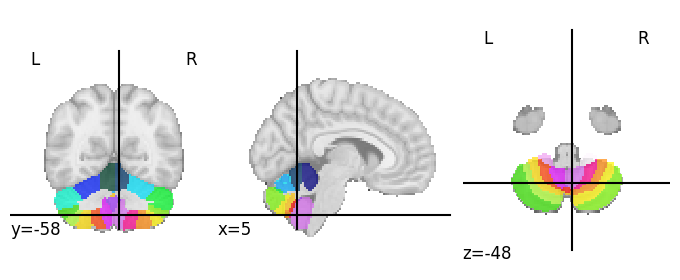

In [25]:
from nilearn import image, plotting 
plotting.plot_roi(cereb_atlas)

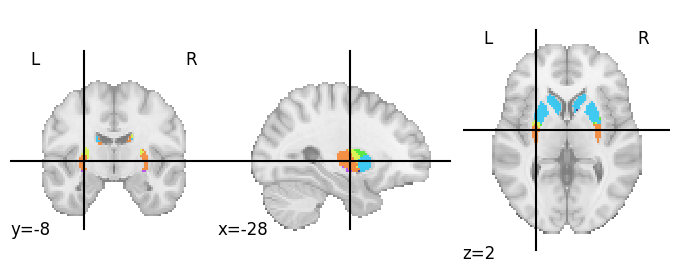

In [26]:
striatum_atlas = nib.load('./inputs/atlases/striatum-con-label-thr25-7sub-2mm.nii.gz')
plotting.plot_roi(striatum_atlas)